# **Understanding Salaries and What Hides Behind Them**
> Theo VIEL - November 2019

In [ ]:
import os
import re
import random
import warnings
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from plotly import tools
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot

sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

seed = 2019
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

questions_only = pd.read_csv('/kaggle/input/kaggle-survey-2019/questions_only.csv')
multiple_choice_responses = pd.read_csv('/kaggle/input/kaggle-survey-2019/multiple_choice_responses.csv', low_memory=False)
header = multiple_choice_responses.iloc[0]
multiple_choice_responses.drop(0, inplace=True)

# Introduction

The idea behind this kernel is to take a look at few factors that determine one's salary, and provide an overall idea of which of those factors actually matter. 

The following question was asked to the 19718 participants of the 2019 Kaggle ML & DS Survey : 

> ### What is your current yearly compensation (approximate \$USD)?

After taking a look at its answers, we'll dive into answers to other questions that seem relevant to study what determines a Kaggler's salary. 
I've selected the following ones : 

In [ ]:
kept_questions = [f'Q{i}' for i in range(1, 9)] + ['Q11','Q15', 'Q23']

with pd.option_context('display.max_colwidth', 10000):
    display(questions_only[kept_questions].T)

Once data has been explored, we'll propose a Machine Learning based approach to compare each of these factors and try to answer this question : 

> ### What matters when a model tries to predict someone's salary ?

Some ideas already come quickly to mind : Age, Experience, Studies, Location ... 

And a controversy already arises : *What about the gender pay gap ?*

# Part 1 - Exploring the Data

# Taking a Look at Incomes

## Missing values

In [ ]:
plt.figure(figsize=(10, 6))
splot = sns.countplot(~multiple_choice_responses['Q10'].isna())
for p in splot.patches:
    splot.annotate(format(p.get_height() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title(f"Income is Provided", size=15)
plt.ylim((0, 13500))
plt.xticks([0, 1], ['No', 'Yes'], fontsize=14)
plt.show()

multiple_choice_responses = multiple_choice_responses[~multiple_choice_responses['Q10'].isna()]

As we are going to focus on income, we need to consider people who gave an answer to the question. Unfortunately, more than a third of the data will be unused for now.

## Repartition

In [ ]:
order = ['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499', '7,500-9,999',
         '10,000-14,999',  '15,000-19,999', '20,000-24,999', '25,000-29,999', '30,000-39,999', 
         '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999', '90,000-99,999',
        '100,000-124,999', '125,000-149,999', '150,000-199,999', '200,000-249,999', '250,000-299,999', '300,000-500,000']

plt.figure(figsize=(15, 12))
splot = sns.countplot(y=multiple_choice_responses['Q10'].fillna('unknown'), order=order)
for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
    
plt.title(questions_only['Q10'][0], size=15)
plt.xlim(0, 1650)
plt.yticks(fontsize=12)
plt.show()

The intuition about income repartition is that it can be decomposed into **two trends** : 
- People that have very few experience, and therefore have low / no income.
- More experienced people, which income's repartition should roughly follow a gaussian distribution

The graph seem to follow this trend although there might be some outliers, which I believe it is better to get rid off.

For visualization, we are going to need integer values of the income. I also keep an extra column with salaries maxed at 200k$.

In [ ]:
multiple_choice_responses = multiple_choice_responses[multiple_choice_responses['Q10'] != '> $500,000']

salaries = [500]
for salary_str in order[1:-1]:
    salary_str = re.sub(',', '', salary_str).split('-')
    salaries.append(int(np.mean([int(salary_str[0]), int(salary_str[1])])) // 100 * 100)
salaries.append(500000)

salary_map = dict(zip(order, salaries))

multiple_choice_responses['salaries'] = multiple_choice_responses['Q10'].map(salary_map)
multiple_choice_responses['salaries_clipped'] = np.clip(multiple_choice_responses['salaries'].values, 0,  200000)

# Age & Experience

They are most likely the first factors that come to mind when determining one's salary.

## Age

In [ ]:
order = ['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49','50-54', '55-59', '60-69', '70+']

plt.figure(figsize=(15, 5))
splot = sns.countplot(multiple_choice_responses['Q1'], order=order)
for p in splot.patches:
    splot.annotate(format(p.get_height() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title(questions_only['Q1'][0], size=15)
plt.ylim(0, 3400)
plt.xticks(fontsize=12)
plt.show()

The age repartition differs from the one of the overall population because Data Science involves new technologies. As a reference, see below the age repartition of Facebook users, which approximately follow the same trend, with the difference that people start using Facebook younger than they start doing Data Science (*unfortunately*)

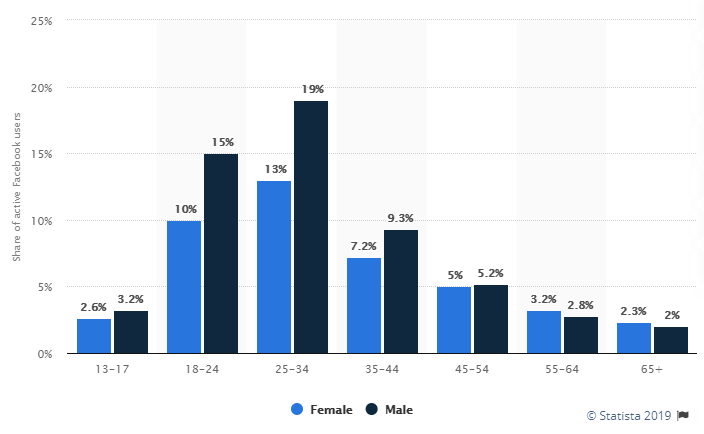

> *Source :* https://www.statista.com/statistics/376128/facebook-global-user-age-distribution/

In [ ]:
order = ['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49','50-54', '55-59', '60-69', '70+']

plt.figure(figsize=(15, 8))
sns.boxplot(x=multiple_choice_responses['Q1'], y=multiple_choice_responses['salaries'], order=order)
plt.title('Age & Salary', size=15)
plt.xticks(fontsize=12)
plt.show()

The analysis is straight forward, **people start from scratch and earn more and more** until they retire in their 70s. 
Once again, I get rid of some outliers, using age as a limiting factor for income.

In [ ]:
multiple_choice_responses = multiple_choice_responses[~((multiple_choice_responses['salaries'] >= 150000) & (multiple_choice_responses['Q1'] == '18-21'))]
multiple_choice_responses = multiple_choice_responses[~((multiple_choice_responses['salaries'] >= 200000) & (multiple_choice_responses['Q1'] == '22-24'))]
multiple_choice_responses = multiple_choice_responses[~((multiple_choice_responses['salaries'] >= 300000) & (multiple_choice_responses['Q1'] == '25-29'))]
multiple_choice_responses = multiple_choice_responses[~((multiple_choice_responses['salaries'] >= 350000) & (multiple_choice_responses['Q1'] == '30-34'))]

## Experience

Experience matters more than age (*hopefully*), although the two are correlated. We'll take a look into the experience in the Machine Learning and Data Analysis fields.

## Experience in ML

In [ ]:
order = ['< 1 years','1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years','10-15 years', '20+ years']

plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
splot = sns.countplot(y=multiple_choice_responses['Q23'], order=order)

for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
    
plt.title(questions_only['Q23'][0], size=15)
plt.yticks(fontsize=12)

order = ['I have never written code', '< 1 years', '1-2 years', '3-5 years', '5-10 years','10-20 years', '20+ years']


plt.subplot(2, 1, 2)
splot = sns.countplot(y=multiple_choice_responses['Q15'], order=order)

for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
    
plt.yticks(fontsize=12)
plt.title(questions_only['Q15'][0], size=15)
plt.show()

Most people have very little experience, and that is normal since Kaggle is a great place for learning. 

In [ ]:
order = ['< 1 years','1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years','10-15 years', '20+ years']

plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
sns.boxplot(y=multiple_choice_responses['Q23'], x=multiple_choice_responses['salaries_clipped'], order=order)
plt.yticks(fontsize=12)
plt.title('ML Experience & Salary', size=15)


order = ['I have never written code', '< 1 years', '1-2 years', '3-5 years', '5-10 years','10-20 years', '20+ years']

plt.subplot(2, 1, 2)
sns.boxplot(y=multiple_choice_responses['Q15'], x=multiple_choice_responses['salaries_clipped'], order=order)
plt.title('Data Analysis Experience & Salary', size=15)
plt.yticks(fontsize=12)
plt.show()

The trend is globally the same as for both topics, although the answer *"I have never written code"* provides some extra information, regarding people who do not do data analysis. Even though it seems like an important skill to master, it is not mandatory depending on the job you do. Same applies for Machine Learning but the data does not tell people who do not do ML and people who did a few appart.

Experience is a bit like age, **the more the better**, with the difference that it is rare to be unable to access top jobs because you have too much experience.

# Who are you ?
We'll take a look at two things that defines a person : gender & country. Those are two things that should not define your income but do play a role.

## Gender

In [ ]:
plt.figure(figsize=(15, 5))
splot = sns.countplot(multiple_choice_responses['Q2'])

for p in splot.patches:
    splot.annotate(format(p.get_height() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.title(questions_only['Q2'][0].split('-')[0], size=15)
plt.ylim(0, 11500)
plt.xticks(fontsize=12)
plt.show()

The fact that Data Science is a **male preserve** immediatly stands out. 

In [ ]:
sns.catplot(y='Q2', x='salaries_clipped', kind="boxen", data=multiple_choice_responses, height=5, aspect=15/5)
plt.title('Gender & Salary', size=15)
plt.yticks(fontsize=12)
plt.show()

Women tend to have lower salaries than men : the usual figure is **78% lower salaries for women** (without adjustments). 

> *Source :* O'Brien, Sara Ashley (April 14, 2015). "78 cents on the dollar: The facts about the gender wage gap"

Also note that there are no women with  >200k$ salaries, which translates to the usual assumption that the highest earning jobs are mostly accessible to men, because of the **glass ceiling**.

Let us take a look at the **wage gap** here. 

In [ ]:
mean_salaries = multiple_choice_responses[['salaries', 'Q2']].groupby('Q2').mean()
mean_salaries.columns = mean_salaries.columns.get_level_values(0)
mean_salaries = mean_salaries.rename(columns={'salaries' : 'Average Salary'})
mean_salaries.head(2)

In [ ]:
print(f"The ratio of Female over Male salary is {40536/49815 * 100 :.0f}%")

Although our this number is approximate, it is close to the commonly used 78%. One may think because it is a relatively recent field, Data Science would have a lower wage gap, but it does not seem to be the case.

## Country

In [ ]:
country_count = multiple_choice_responses[['Q3', 'salaries']].groupby('Q3').count().reset_index()
country_count['salaries_mean'] = multiple_choice_responses[['Q3', 'salaries']].groupby('Q3').mean()['salaries'].values // 1000 * 1000

# Taken from https://www.kaggle.com/artgor/russia-usa-india-and-other-countries/
country_code = pd.read_csv('../input/plotly-country-code-mapping/2014_world_gdp_with_codes.csv')

country_count.loc[country_count['Q3'] == 'United States of America', 'Q3'] = 'United States'
country_count.loc[country_count['Q3'] == 'United Kingdom of Great Britain and Northern Ireland', 'Q3'] = 'United Kingdom'
country_count.loc[country_count['Q3'] == 'South Korea', 'Q3'] = '"Korea, South"'
country_count.loc[country_count['Q3'] == 'Viet Nam', 'Q3'] = 'Vietnam'
country_count.loc[country_count['Q3'] == 'Iran, Islamic Republic of...', 'Q3'] = 'Iran'
country_count.loc[country_count['Q3'] == 'Hong Kong (S.A.R.)', 'Q3'] = 'Hong Kong'
country_count.loc[country_count['Q3'] == 'Republic of Korea', 'Q3'] = '"Korea, North"'

country_count = pd.merge(country_count, country_code, left_on='Q3', right_on='COUNTRY')

In [ ]:
data = [dict(type='choropleth',
             locations=country_count['CODE'],
             z=country_count['salaries'],
             text=country_count['Q3'],
             colorscale='Viridis',
             autocolorscale=False,
             reversescale=True,
             marker = dict(line=dict(color='rgb(180,180,180)', width=0.5)),
             colorbar = dict(autotick=False, title='Responders'),)
       ]

layout = dict(
    title = 'Responders by Country',
    geo = dict(showframe=False, showcoastlines=True, projection=dict(type='Mercator'))
)

fig = dict( data=data, layout=layout )
iplot( fig, validate=False, filename='d3-world-map' )

The country induces a lot of **bias** in our analysis, because the **cost of life** is depends on where you live. Salaries adapt to that and therefore tend to be higher in develloped countries. India and the USA are the two most represented countries, and they are very different examples here.

In [ ]:
data = [dict(type='choropleth',
             locations=country_count['CODE'],
             z=country_count['salaries_mean'],
             text=country_count['Q3'],
             colorscale='Viridis',
             autocolorscale=False,
             reversescale=True,
             marker = dict(line=dict(color='rgb(180,180,180)', width=0.5)),
             colorbar = dict(autotick=False, title='Responders'),)
       ]

layout = dict(
    title = 'Average Salary (USD) by Country',
    geo = dict(showframe=False, showcoastlines=True, projection=dict(type='Mercator'))
)

fig = dict(data=data, layout=layout)
iplot(fig, validate=False, filename='d3-world-map')

USA's average salary is 7 times higher than the one in India, but as I said it is mostly because of the cost of life.

As a comparison, here is a map of the cost of living in different countries.

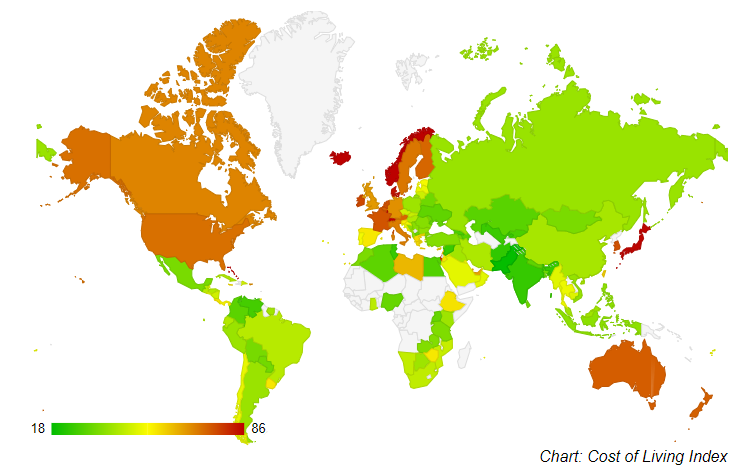
> *Source :* https://www.numbeo.com/cost-of-living/rankings_by_country.jsp

The two maps seem to match out pretty well, even though there are some exceptions :
- Salaries in the USA still seem to be pretty high : This is justified because the USA is not a **Welfare State**, i.e. it does not guarantee lot of social measures for its citizens, as opposed to most of the European countries
- Japan seems to have really low salaries compared to the price of life

# What is your job ?

Let us take a look at what people do for a living, and what they did to get there.

## Education

In [ ]:
order = ['No formal education past high school', 'Some college/university study without earning a bachelor’s degree', 'Professional degree', 
         'Bachelor’s degree', 'Master’s degree', 'Doctoral degree', 'I prefer not to answer']

shorter = ['No formal education past high school', 'Some college/university study', 'Professional degree', 'Bachelor’s degree',  
           'Master’s degree', 'Doctoral degree', 'I prefer not to answer']

plt.figure(figsize=(15, 7))
splot = sns.countplot(y=multiple_choice_responses['Q4'], order=order)

for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
    
plt.title(questions_only['Q4'][0], size=15)
plt.yticks(range(len(order)), shorter, fontsize=12)
plt.show()

Almost half of Kagglers have a Master's Degree, which is a very high education level compared to the norm.

In [ ]:
plt.figure(figsize=(15, 7))
sns.boxplot(y=multiple_choice_responses['Q4'], x=multiple_choice_responses['salaries_clipped'], order=order)
plt.yticks(range(len(order)), shorter)
plt.title('Education & Salary', size=15)
plt.yticks(fontsize=12)
plt.show()

Overall, the two formations that bring the more money are Master's degrees and Doctoral degrees, for they are the ones that last the longer. Usually, **the more you study, the higher your salary will be**, this is true at least at the beginning of your career.

## Actual Job

In [ ]:
order = list(np.array(sorted(Counter(multiple_choice_responses['Q5']).items(), key=operator.itemgetter(1)))[:, 0][::-1])
order.remove('Other')
order.append('Other')

plt.figure(figsize=(15, 8))
splot = sns.countplot(y=multiple_choice_responses['Q5'], order=order)

for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
    
plt.yticks(fontsize=12)
plt.title(questions_only['Q5'][0].split(':')[0], size=15)
plt.show()

Harvard Buisness Review named **Data Scientist** the sexiest job of the 21st century, no wonder why it is on top here.

> See https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(y=multiple_choice_responses['Q5'], x=multiple_choice_responses['salaries_clipped'], order=order)
plt.title('Role & Salary', size=15)
plt.yticks(fontsize=12)
plt.show()

**Data Scientists** and **Product / Project Manager** seem to be the best earning "data" jobs.
We saw before that people having doctoral degrees tend to earn more. However, research oriented jobs such as **Research Scientist** do not seem to be the highest paid ones.
We dive a bit deeper in the data to understand that.

In [ ]:
plt.figure(figsize=(15, 6))
splot = sns.countplot(multiple_choice_responses['Q5'], hue=multiple_choice_responses['Q4'], order=['Data Scientist', 'Research Scientist', 'Product/Project Manager'])

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, 2050)
plt.title('Job Title & Studies', size=15)
plt.xticks(fontsize=12)
plt.show()

It seems that a lot of people with PhDs end up as Data Scientists, where they will overall be paid more than those with Master's degrees. However, the definition of a Data Scientist has become really large.

In [ ]:
counts = {}
for c in ['Q9_Part_1', 'Q9_Part_2', 'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6']:
    col = header[c].split(' - ')[-1]
    counts[col] = (~multiple_choice_responses[multiple_choice_responses['Q5'] == 'Data Scientist'][c].isna()).sum()

shorter = ['Analyze and understand data to \n influence product or business decisions',
 'Build and/or run the data infrastructure \n that my business uses for storing, \n analyzing, and operationalizing data',
 'Build prototypes to explore applying \n machine learning to new areas',
 'Build and/or run a ML service \n  that operationally improves \n  my product or workflows',
 'Experimentation and iteration \n to improve existing ML models',
 'Do research that advances \n the state of the art of ML',]

plt.figure(figsize=(15, 8))
splot = sns.barplot(y=list(counts.keys()), x=list(counts.values()))

for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
    
plt.title("Data Scientists : " + questions_only['Q9'][0].split(':')[0], size=15)
plt.yticks(range(len(shorter)), shorter, fontsize=12)
plt.show()

It appears that the Data Scientist combines competences of the **Analysts** ("Analyze and understand data to influence product or business decisions"), of the **Engineers** 
("Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",  "Build and/or run a ML service that operationally improves my product or workflows") and of the **Researchers** ("Do research that advances the state of the art of ML").

# Who do you Work for ?

Your employer chooses your salary so companies are definitely worth to take a look into.

## Company size

In [ ]:
order = ['0-49 employees', '50-249 employees', '250-999 employees', '1000-9,999 employees', '> 10,000 employees']
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)

splot = sns.countplot(y=multiple_choice_responses['Q6'], order=order)
for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.0f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
plt.title("Number of Employees", size=15)
plt.xlim(0, 3800)
plt.yticks(range(len(order)), [o[:-10] for o in order], fontsize=12)
# plt.show()

order = ['0', '1-2', '3-4', '5-9', '10-14', '15-19', '20+']

plt.subplot(1, 2, 2)
splot = sns.countplot(y=multiple_choice_responses['Q7'], order=order)
for p in splot.patches:
    splot.annotate(format(p.get_width() / len(multiple_choice_responses) * 100, '.0f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                   ha='center', va='center', xytext=(15, 0), textcoords='offset points')
plt.title("Number of Data Science Employees", size=15)
plt.xlim(0, 3100)
plt.yticks(fontsize=12)
plt.show()

Data Science is a **start-up** oriented field, making small size companies (<50) the most represented category here.

In [ ]:
order = ['0-49 employees', '50-249 employees', '250-999 employees', '1000-9,999 employees', '> 10,000 employees']
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.boxplot(y=multiple_choice_responses['Q6'], x=multiple_choice_responses['salaries_clipped'], order=order)
plt.yticks(range(len(order)), [o[:-10] for o in order], fontsize=12)
plt.title('Number of Employees & Salary', size=15)

order = ['0', '1-2', '3-4', '5-9', '10-14', '15-19', '20+']
plt.subplot(1, 2, 2)
sns.boxplot(y=multiple_choice_responses['Q7'], x=multiple_choice_responses['salaries_clipped'], order=order)
plt.title('Number of Data Science Employees & Salary', size=15)
plt.yticks(fontsize=12)
plt.show()

Nothing much to say here, except that the bigger the employer, the higher the salary. 

## Importance of Machine Learning in the Company

In [ ]:
order = [#'I do not know',
         'No (we do not use ML methods)',
         'We are exploring ML methods (and may one day put a model into production)',
         'We use ML methods for generating insights (but do not put working models into production)',
         'We recently started using ML methods (i.e., models in production for less than 2 years)',
         'We have well established ML methods (i.e., models in production for more than 2 years)',
        ]

shorter = [#'I do not know',
           'No',
           'We are exploring \n ML methods',
           'We use ML methods \n for generating insights',
           'We recently started \n using ML methods',
           'We have well \n established ML methods',
          ]

sns.catplot(y='Q8', x='salaries_clipped', kind="boxen", data=multiple_choice_responses, height=6, aspect=18/6, order=order)
plt.title('Maturity of the Employer in ML & Salary', size=15)
plt.yticks(range(len(order)), shorter, fontsize=12)
plt.show()

As expected, employers that are more **mature** in Machine Learning tend to pay employees in the ML related fields more, especially when the company has developed a need for data science teams. The better Machine Learning is used in the firm, the higher the value of the Data Scientist (and other jobs).

In [ ]:
order = ['$0 (USD)', '$1-$99', '$100-$999', '$1000-$9,999', '$10,000-$99,999', '> $100,000 ($USD)']

sns.catplot(y='Q11', x='salaries_clipped', kind="boxen", data=multiple_choice_responses, height=6, aspect=18/6, order=order)
plt.title('Budget spent on ML at work & Salary', size=15)
plt.yticks(fontsize=12)
plt.show()

This is straight-forward as well, people who can spend the more money doing their Machine Learning job are also the one that have the highest salary. Ironically, **the more you spend, the more you earn**.

# Part 2 - Getting New Insights 

So far, we've used a straight forward approach to look at what influences salary. I'm going to use one that uses common Machine Learning tools to put in perspective everything that was observed so far. 

# Predicting Salaries

Let us say we want to predict the income of a person. I will tackle the problem as a classification one. In fact, a regression one will give a bad results on lower salaries. I believe it is more important to make a distinction between earning 40k and 60k than between earning 200k and 250k.

Therefore, I make **6 salary categories**:
- Less than 10k - *(Newbie)*
- Between 10k and 30k - *(Casual Player)*
- Between 30k and 50k - *(Average Player)*
- Between 50k and 80k - *(Try Harder)*
- Between 80k and 125k - *(Pro Player)*
- More than 125k  - *(Hacker)*

In [ ]:
df = multiple_choice_responses[kept_questions + ['salaries']].copy()

classes = ['< 10k', '10k - 30k', '30k - 50k', '50k - 80k', '80k - 125k', '> 125k']

dic_target = {500: 0, 1400: 0, 2400: 0, 3400: 0, 4400: 0, 6200: 0, 8700:0, 
              12400: 1, 17400: 1, 22400: 1, 27400:1, 37100: 1,
              34900: 2, 44900: 2, 
              54900: 3,  64900: 3,  74900: 3,
              84900: 4, 94900: 4, 112400: 4,
              137400: 5,  174900: 5, 224900: 5, 274900: 5, 500000: 5}

df['salaries'] = df['salaries'].apply(lambda x: dic_target[x])


plt.figure(figsize=(12, 7))
splot = sns.countplot(df['salaries'])

for p in splot.patches:
    splot.annotate(format(p.get_height() / len(multiple_choice_responses) * 100, '.1f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title(f"Repartition of our Income Classes", size=15)
plt.xticks(range(0, 7), classes, fontsize=14)
plt.show()

I also rename columns for more clarity. The features used are those studied earlier.

In [ ]:
df = df.rename(index=str, columns={"Q1": 'Age', "Q2": 'Gender', "Q3": 'Country', "Q4": 'Education', "Q5": 'Job', "Q6": 'Employer -  Size', 
                                   "Q7": 'Employer - DS Size', "Q8": "Employer - ML Maturity", "Q11": "Employer - ML Budget", 
                                   "Q15": "Exp - Coding", "Q23": "Exp - ML", "salaries" : 'Target',
                                  })

features = list(df.columns[:-1])
print('Using features : ',  ', '.join(features))

# Preparing Input Data
This is the boring part when I treat features to make them fit in a model.
I first deal with purely categorical columns : **Country** and **Job**

In [ ]:
cat_cols = ['Country', 'Job']

for q in cat_cols:
    df[q] = df[q].astype('category')
    
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

Then I deal with columns that have an order that I want to keep, or that I want to manually define categories for.
- **Age**, **Employer -  Size**, **Employer - DS Size**,  **Employer - ML Budget**, **Exp - Coding**, **Exp - ML**: Which are basically numerical features
- **Gender** : I merge the two under-represented categories
- **Education** : I encode it using the (approximated) length of the studies
- **Employer - ML Maturity** : "Higher maturity" categories get a higher value for encoding

In [ ]:
dic_age = {'18-21': 19.5, '22-24': 23, '25-29': 27, '30-34': 32, '35-39': 37, '40-44': 42, '45-49': 47, '50-54': 52,'55-59': 57, '60-69': 64.5,'70+': 75}

dic_gender = {'Male': 0, 'Female': 1, 'Prefer to self-describe': 2, 'Prefer not to say': 2}

dic_education = {'No formal education past high school' : 0, 'Some college/university study without earning a bachelor’s degree': 1, 
                 'Professional degree': 3, 'Bachelor’s degree': 3, 'Master’s degree': 5, 'Doctoral degree': 8, 'I prefer not to answer': 3}

dic_company_size = {'0-49 employees': 25, '50-249 employees': 175, '250-999 employees': 625, '1000-9,999 employees': 5500, '> 10,000 employees': 15000}

dic_ds_team_size = {'0': 0, '1-2': 1.5, '3-4': 3.5, '5-9': 7, '10-14': 12, '15-19': 17, '20+': 25}

dic_employer_mat = {'I do not know': 0, 'No (we do not use ML methods)': 0,
                    'We are exploring ML methods (and may one day put a model into production)': 1,
                    'We use ML methods for generating insights (but do not put working models into production)': 2,
                    'We recently started using ML methods (i.e., models in production for less than 2 years)': 3,
                    'We have well established ML methods (i.e., models in production for more than 2 years)': 4,
                   }
dic_budget = {'$0 (USD)': 1, '$1-$99': 50, '$100-$999': 550, '$10,000-$99,999': 55000,  '$1000-$9,999': 5500, '> $100,000 ($USD)': 100000}

dic_exp_code = {'I have never written code': 0, '< 1 years': 0.5, '1-2 years': 1.5, '3-5 years': 4, '5-10 years': 7.5, '10-20 years': 15,  '20+ years': 20}

dic_exp_ml = {'< 1 years': 0.5, '1-2 years': 1.5, '2-3 years': 2.5, '3-4 years': 3.5, '4-5 years': 4.5, '5-10 years': 7.5, '10-15 years': 12.5, '20+ years': 20}


dic_cols = ['Age', 'Gender', 'Education', 'Employer -  Size', 'Employer - DS Size', 'Employer - ML Maturity', 'Employer - ML Budget', 'Exp - Coding', 'Exp - ML']
dics = [dic_age, dic_gender, dic_education, dic_company_size, dic_ds_team_size, dic_employer_mat, dic_budget, dic_exp_code, dic_exp_ml]

assert len(dics) == len(dic_cols )

def replace_with_dic(dic, x):
    """Function to apply a mapping that handles missing values"""
    try:
        return dic[x]
    except KeyError:
        return x

for col, dic in zip(dic_cols, dics):
    df[col] = df[col].apply(lambda x: replace_with_dic(dic, x))
    
cat_cols.append('Gender')

I also get rid of missing values by using the mean of the feature, and apply log scaling to features with a too high range (**Employer - ML Budget** and **Employer -  Size**)

In [ ]:
df.fillna(df.mean(), inplace=True)

df['Employer - ML Budget'] = np.log(df['Employer - ML Budget'])
df['Employer -  Size'] = np.log(df['Employer -  Size'])

# Modeling

Next step is to train a model. I use a LightGBM, but any model that handles multi-class data and has some kind of feature importance works (*e.g. Random Forests, Logistic Regression*)

I first split the data in two and then train my model.

In [ ]:
def run_lgb(df_train, df_test, features, target_name='target', cat_features=[]):
    params = {"objective" : "multiclass",
              "num_class": 6,
              "metric" : "multi_error",
              "num_leaves" : 10,
              "min_child_weight" : 5,
              "learning_rate" : 0.02,
              "bagging_fraction" : 0.5,
              "feature_fraction" : 0.5,
              "bagging_seed" : 420,
              "verbosity" : -1
             }
    
    lg_train = lgb.Dataset(df_train[features], label=(df_train[target_name].values), categorical_feature=cat_features)
    lg_test = lgb.Dataset(df_test[features], label=(df_test[target_name].values), categorical_feature=cat_features)
    
    model = lgb.train(params, lg_train, 1000, valid_sets=[lg_test], early_stopping_rounds=100, verbose_eval=100)
    return model


df_train, df_test = train_test_split(df, test_size=0.2)

print(f" -> Training on {df_train.shape[0]} samples.\n")

model = run_lgb(df_train, df_test, features, target_name='Target', cat_features=cat_cols)

print('\n -> Predicting... \n')
pred_train = model.predict(df_train[features], num_iteration=model.best_iteration)
pred_test = model.predict(df_test[features], num_iteration=model.best_iteration)

print('Done !')

# Performances
We want to make sure our model actually learned something. For this, we plot the confusion matrix on test data.

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=12)
    plt.xlabel('Predicted label', size=12)
    
conf_mat_train = confusion_matrix(np.argmax(pred_train, axis=1), df_train['Target'].values)
conf_mat_test = confusion_matrix(np.argmax(pred_test, axis=1), df_test['Target'].values)

plot_confusion_matrix(conf_mat_test, classes, title='Confusion matrix on test data', normalize=True)

**Results are pretty good** overall. The model struggles a bit to distinguish close classes but it is normal. 
Also, the extremes cases are the easier to detect, which makes sense.

Now that we have a model that converged, let us move on to the interesting part :

# Feature Importance

In [ ]:
def plot_feature_importance(ft_imp):
    """
    Plots feature importance given a dictionary
    :param ft_imp: Dictionary of form {feature (str): importance (float)
    :return: None
    """
    plt.figure(figsize=(12, 8))
    order = np.array(sorted(ft_imp.items(), key=operator.itemgetter(1)))[:, 0][::-1]
    vals = np.array(sorted(ft_imp.items(), key=operator.itemgetter(1)))[:, 1][::-1].astype(float)
    splot = sns.barplot(y=order, x=vals)

    for p in splot.patches:
        splot.annotate(format(p.get_width() / np.sum(vals) * 100, '.0f') + '%', (p.get_width() * 1.01, p.get_y() + p.get_height() / 2),
                       ha='center', va='center', xytext=(15, 0), textcoords='offset points')
    plt.yticks(fontsize=12)
    plt.title('Feature importance', size=15)
    
    
importances_dic = dict(zip(df.columns[:-1], model.feature_importance()))

plot_feature_importance(importances_dic)
plt.xlim(0, np.max(model.feature_importance()) * 1.07)
plt.show()

### A couple of things stand out : 
- The **country** is the most important feature, this was expected as we already raised the issue of the cost of life influence.
- **Age** is more important than **experience**, I believe this is because the two experience features are a bit too specific and one can have a high salary without knowing a lot about one of the fields.
- **Gender** and **Education** matter the least !
 - People in Data Science are overall highly educated, therefore it does not seem to play a big role for the model. It is what you do more than what you did that will determine your income.
 - The model believes that if only the gender differs, both people will have the same salary. This does not mean that the gender pay gap does not exist: for instance, women still struggle to reach higher positons.
 

*Be careful that results vary a bit, and they come out of a black box, so take them for what they are worth.*

# Conclusion

## Takeaways 

By taking a look into some relevant questions of the survey, I've highlighted some relevant factors to analyse salaries. The order is random, and you may or may not agree with these insights.

- Salaries depend *a lot* on where you live
- Your job matters more than your studies
- Salary is a strictly increasing function of both age and experience
- If your employer has more means, you are most likely going to get paid more
- Gender plays a role, but is not necessarily a determining factor : its influence is too *under-cover* for a naive model to understand it

## Digging deeper ...

It appeared that the country is the most important factor in determining your salary. However, it is *in my opinion* not a clever parameter, as it does not tell anything interesting about the person. An idea will be to remove this bias by studying the gap between one's salary and the average salary in the country. Most analysis will stay the same, but this will enable us to leave this parameter appart.

I did a similar task last year, with a more intensive focus on gender (*see https://www.kaggle.com/theoviel/kagglers-gender-pay-gap-salary-prediction*). The features that were the most important were, in this order : *Industry of work, Profession, Country, Age, Experience, Major, Education* and *Gender*. Notice that although the features were different, the order is roughly the same. 

## Final words

It may seem like this work revolves around money, well it is a bit the case. In my honest opinion, salary can be seen as a reward for working, but should not be the thing that makes you work. Although it may be a bit too personal, one thing I would like to see in next year's survey is a question about how people feel about their work. Taking a look at what makes people happy brings much more than taking a look at what makes people "rich". 

> Thanks for Reading ! 

**Theo.**